### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#conda install -c conda-forge shapely
#pip install shap

In [3]:
import shap
shap.initjs()

In [4]:
import pandas as pd
import numpy as np
from io import StringIO
import requests

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00562/Shill Bidding Dataset.csv"
data_text = requests.get(url).text
data_file = StringIO(data_text)
#data = pd.read_csv(data_file, index_col='Record_ID')
data = pd.read_csv(data_file)
data.head(3)

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.4,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.2,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.2,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0


### 2. Сделать обзорный анализ выбранного датасета.

In [6]:
data_copy = data.copy()

**Начальный анализ данных этого датасета был произведён в предыдущем ДЗ(6). Не буду повторятся, выполню необходимые операции.** 

In [7]:
df = data_copy.drop(['Bidder_ID','Record_ID'], axis=1)
df.head(3)

,Auction_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,732,0.200000,0.4,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,732,0.024390,0.2,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,732,0.142857,0.2,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0


In [8]:
#  НОРМАЛИЗАЦИЯ, так как большинство значений уже находятся в диапазоне от 0 до 1, кроме Auction_ID и Auction_Duration,
# необходимо нормализовывать только эти два значения.
df1 = df[['Auction_ID','Auction_Duration']]
df2 = df.drop(columns = ['Auction_ID','Auction_Duration'])
minmax = MinMaxScaler().fit(df1)
minmax = minmax.transform(df1)
df1 = pd.DataFrame(minmax, columns = ['Auction_ID','Auction_Duration'])
df = df1.join(df2, how='outer')
df.head(5)

,Auction_ID,Auction_Duration,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Class
0,0.287011,0.444444,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,0
1,0.287011,0.444444,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,0
2,0.287011,0.444444,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,0
3,0.287011,0.444444,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,0
4,0.353336,0.666667,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,0


In [9]:
df.describe()

,Auction_ID,Auction_Duration,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Class
count,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000
mean,0.488112,0.401677,0.142541,0.127670,0.103781,0.463119,0.231606,0.472821,0.430683,0.367731,0.106787
std,0.290474,0.274070,0.197084,0.131530,0.279698,0.380097,0.255252,0.489912,0.380785,0.436573,0.308867
min,0.000000,0.000000,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.230557,0.222222,0.027027,0.043478,0.000000,0.047928,0.000000,0.000000,0.026620,0.000000,0.000000
50%,0.489933,0.444444,0.062500,0.083333,0.000000,0.440937,0.142857,0.000000,0.360104,0.000000,0.000000
75%,0.735097,0.666667,0.166667,0.166667,0.000000,0.860363,0.454545,0.993593,0.826761,0.851852,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.999900,0.788235,0.999935,0.999900,1.000000,1.000000


### 3. сделать feature engineering

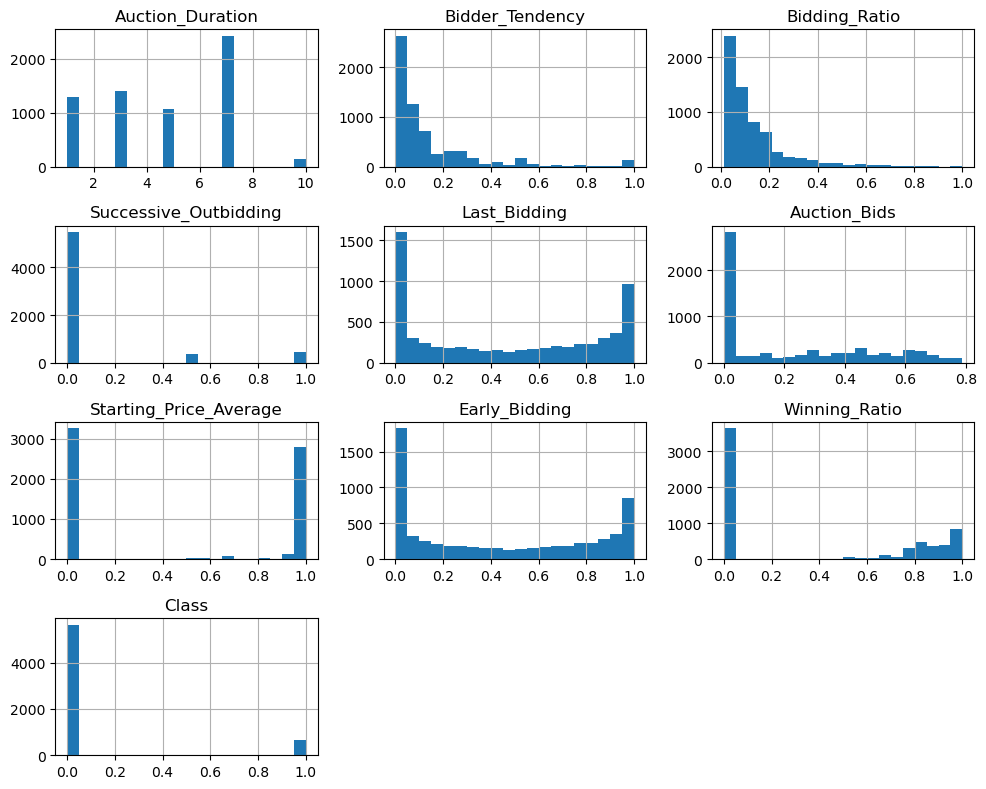

In [10]:
# Построение гистограмм для признаков преобразованных в числовые переменные
numeric_columns = ['Auction_Duration','Bidder_Tendency','Bidding_Ratio','Successive_Outbidding',
                   'Last_Bidding','Auction_Bids','Starting_Price_Average','Early_Bidding','Winning_Ratio','Class']
data[numeric_columns].hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()

Информация об атрибутах:

- **Record_ID:** уникальный идентификатор записи в наборе данных.
- **Auction_ID:** Уникальный идентификатор аукциона.
- **Bidder_ID:** Уникальный идентификатор участника торгов.
- **Bidder_Tendency:** Подставные участники торгов участвуют исключительно в аукционах нескольких продавцов, а не в диверсифицированных лотах. Это сговор между продавцом-мошенником и сообщником.
- **Bidding_Ratio:** подставной участник торгов участвует чаще, чтобы поднять цену аукциона и привлечь более высокие ставки от законных участников.
- **Successive_Outbidding:** подставной участник торгов последовательно перебивает сам себя, даже если он является текущим победителем, чтобы постепенно увеличивать цену с небольшими последовательными приращениями.
- **Last_Bidding:** Подставной участник становится неактивным на последней стадии аукциона (более 90\% продолжительности аукциона), чтобы не выиграть аукцион.
- **Auction_Bids:** Аукционы с деятельностью SB, как правило, имеют гораздо большее количество ставок, чем среднее количество ставок на параллельных аукционах.
- **Starting_Price_Average:** подставной участник обычно предлагает небольшую стартовую цену, чтобы привлечь на аукцион законных участников торгов.
- **Early_Bidding:** подставные торги обычно делают ставки довольно рано на аукционе (менее 25% от продолжительности аукциона), чтобы привлечь внимание пользователей аукциона.
- **Winning_Ratio:** подставной участник торгов участвует во многих аукционах, но почти не выигрывает ни одного аукциона.
- **Auction_Duration:** как долго длился аукцион.
- **Class:**  *0 - для нормального поведения торгов; 1 - НЕ нормального поведения торгов.*

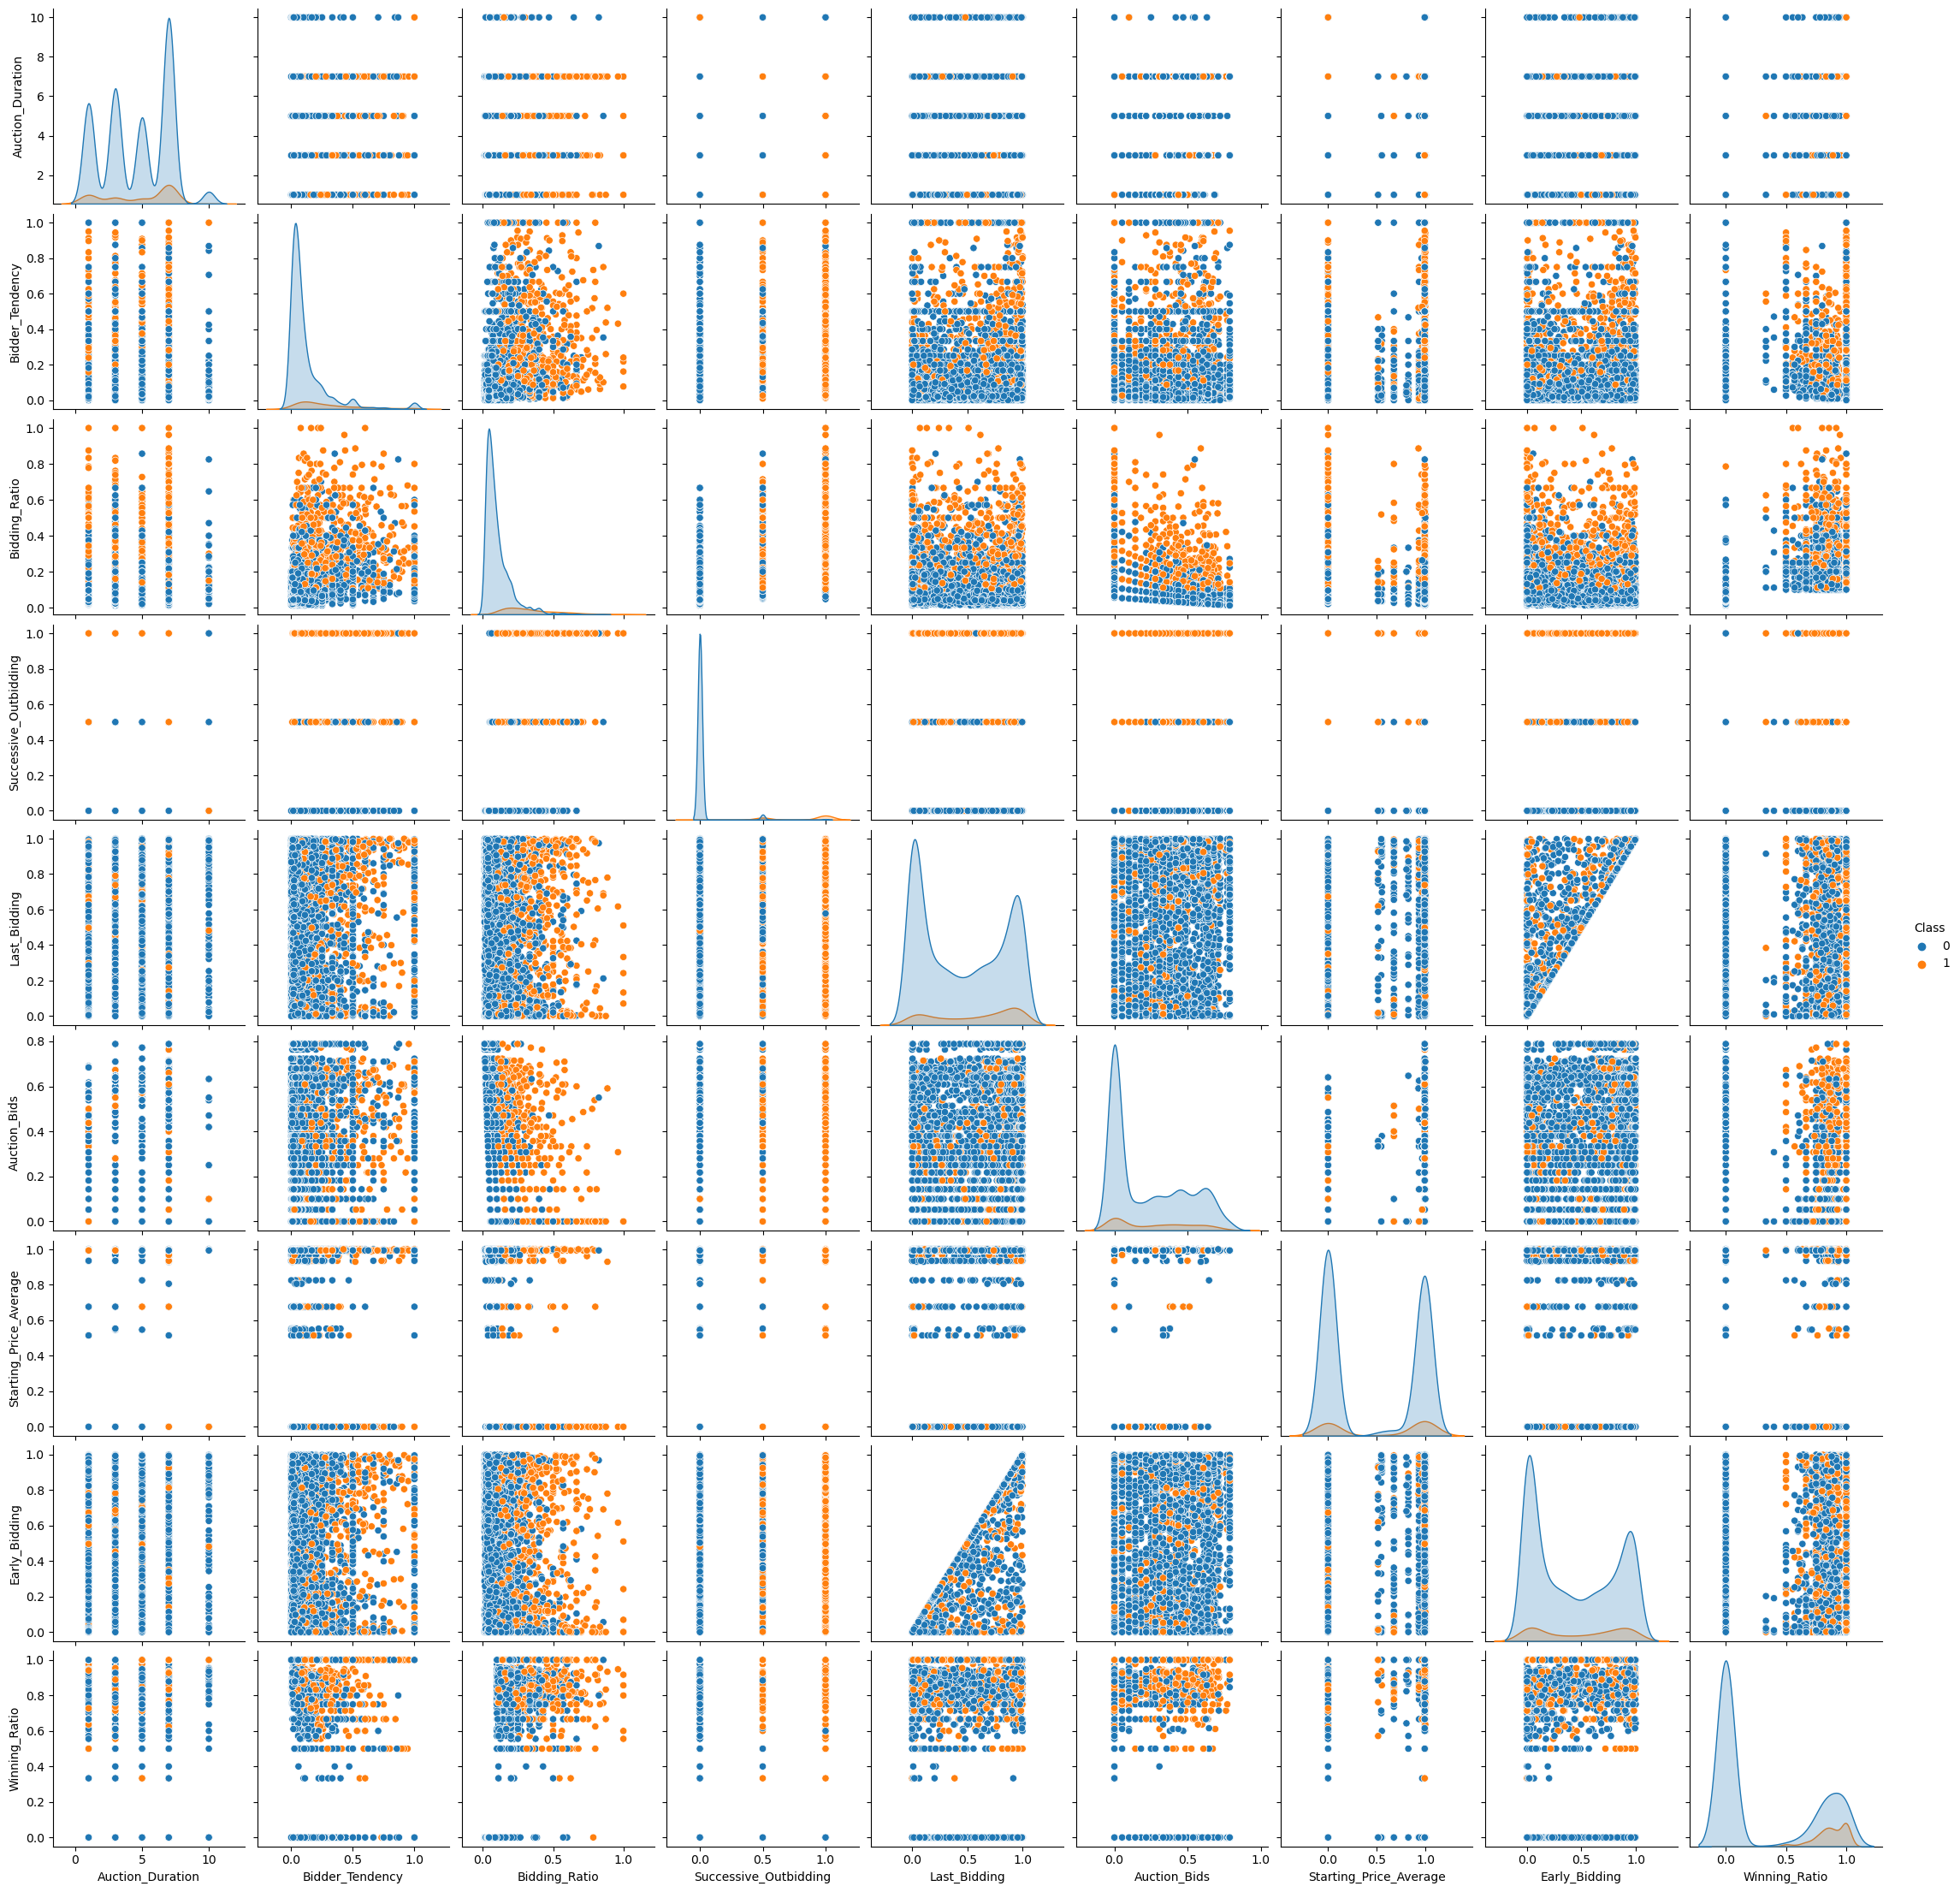

In [11]:
# Диаграммы рассеяния для изучения взаимосвязей
sns.pairplot(data, vars=['Auction_Duration','Bidder_Tendency','Bidding_Ratio','Successive_Outbidding',
                   'Last_Bidding','Auction_Bids',	'Starting_Price_Average','Early_Bidding','Winning_Ratio'], hue='Class')
plt.show()

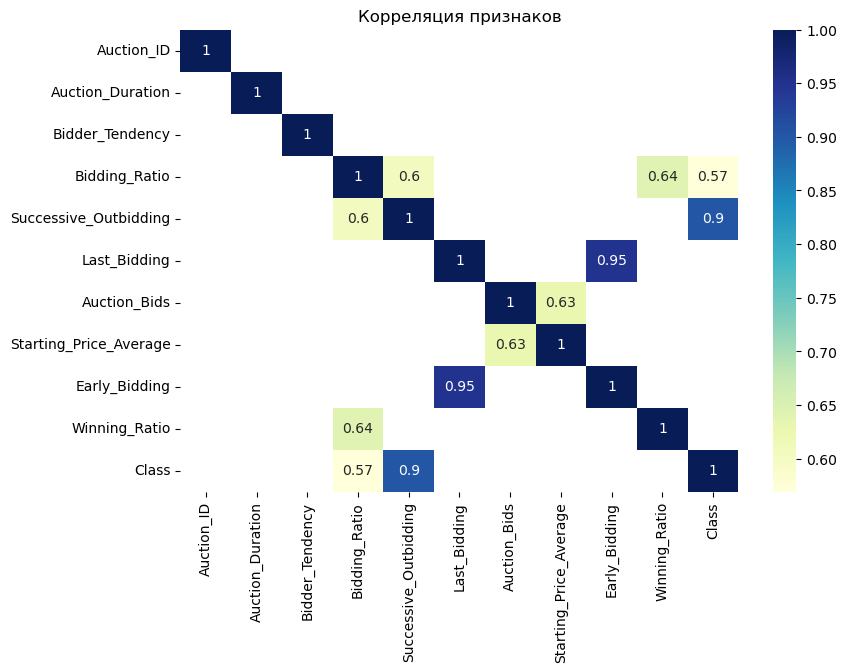

In [12]:
### Проверим корреляцию признаков
corr = df.corr()
filt_corr = corr[np.abs(corr) >= 0.5]

plt.figure(figsize=(9, 6))
sns.heatmap(filt_corr, cmap="YlGnBu", annot=True)
plt.title("Корреляция признаков")
plt.show()

В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

### 4. Обучить любой классификатор (какой вам нравится)

Чтобы получить ответ на вопрос - Какие функции наиболее важны для прогнозирования класса ставок,  используем DecisionTreeClassifier,
который ранжирует признаки по их важности.
Важность функции рассчитывается как уменьшение примеси узла, взвешенное по вероятности достижения этого узла.
Вероятность узла может быть рассчитана путем деления количества выборок, достигших узла, на общее количество выборок.
Чем выше значение, тем важнее функция.

In [13]:
# отделю независимые переменные от зависимой переменной.
X = df.drop(columns = 'Class')
y = df['Class']

Модель - 'DecisionTreeClassifier'

In [14]:
cls = DecisionTreeClassifier()
cls.fit(X, y)

DecisionTreeClassifier()

In [15]:
importances = cls.feature_importances_
columns = X.columns
columns

Index(['Auction_ID', 'Auction_Duration', 'Bidder_Tendency', 'Bidding_Ratio',
       'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids',
       'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio'],
      dtype='object')

### 5. разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%

**Построим график для отображения важности функций в порядке убывания.**

Text(0, 0.5, 'Процент важности')

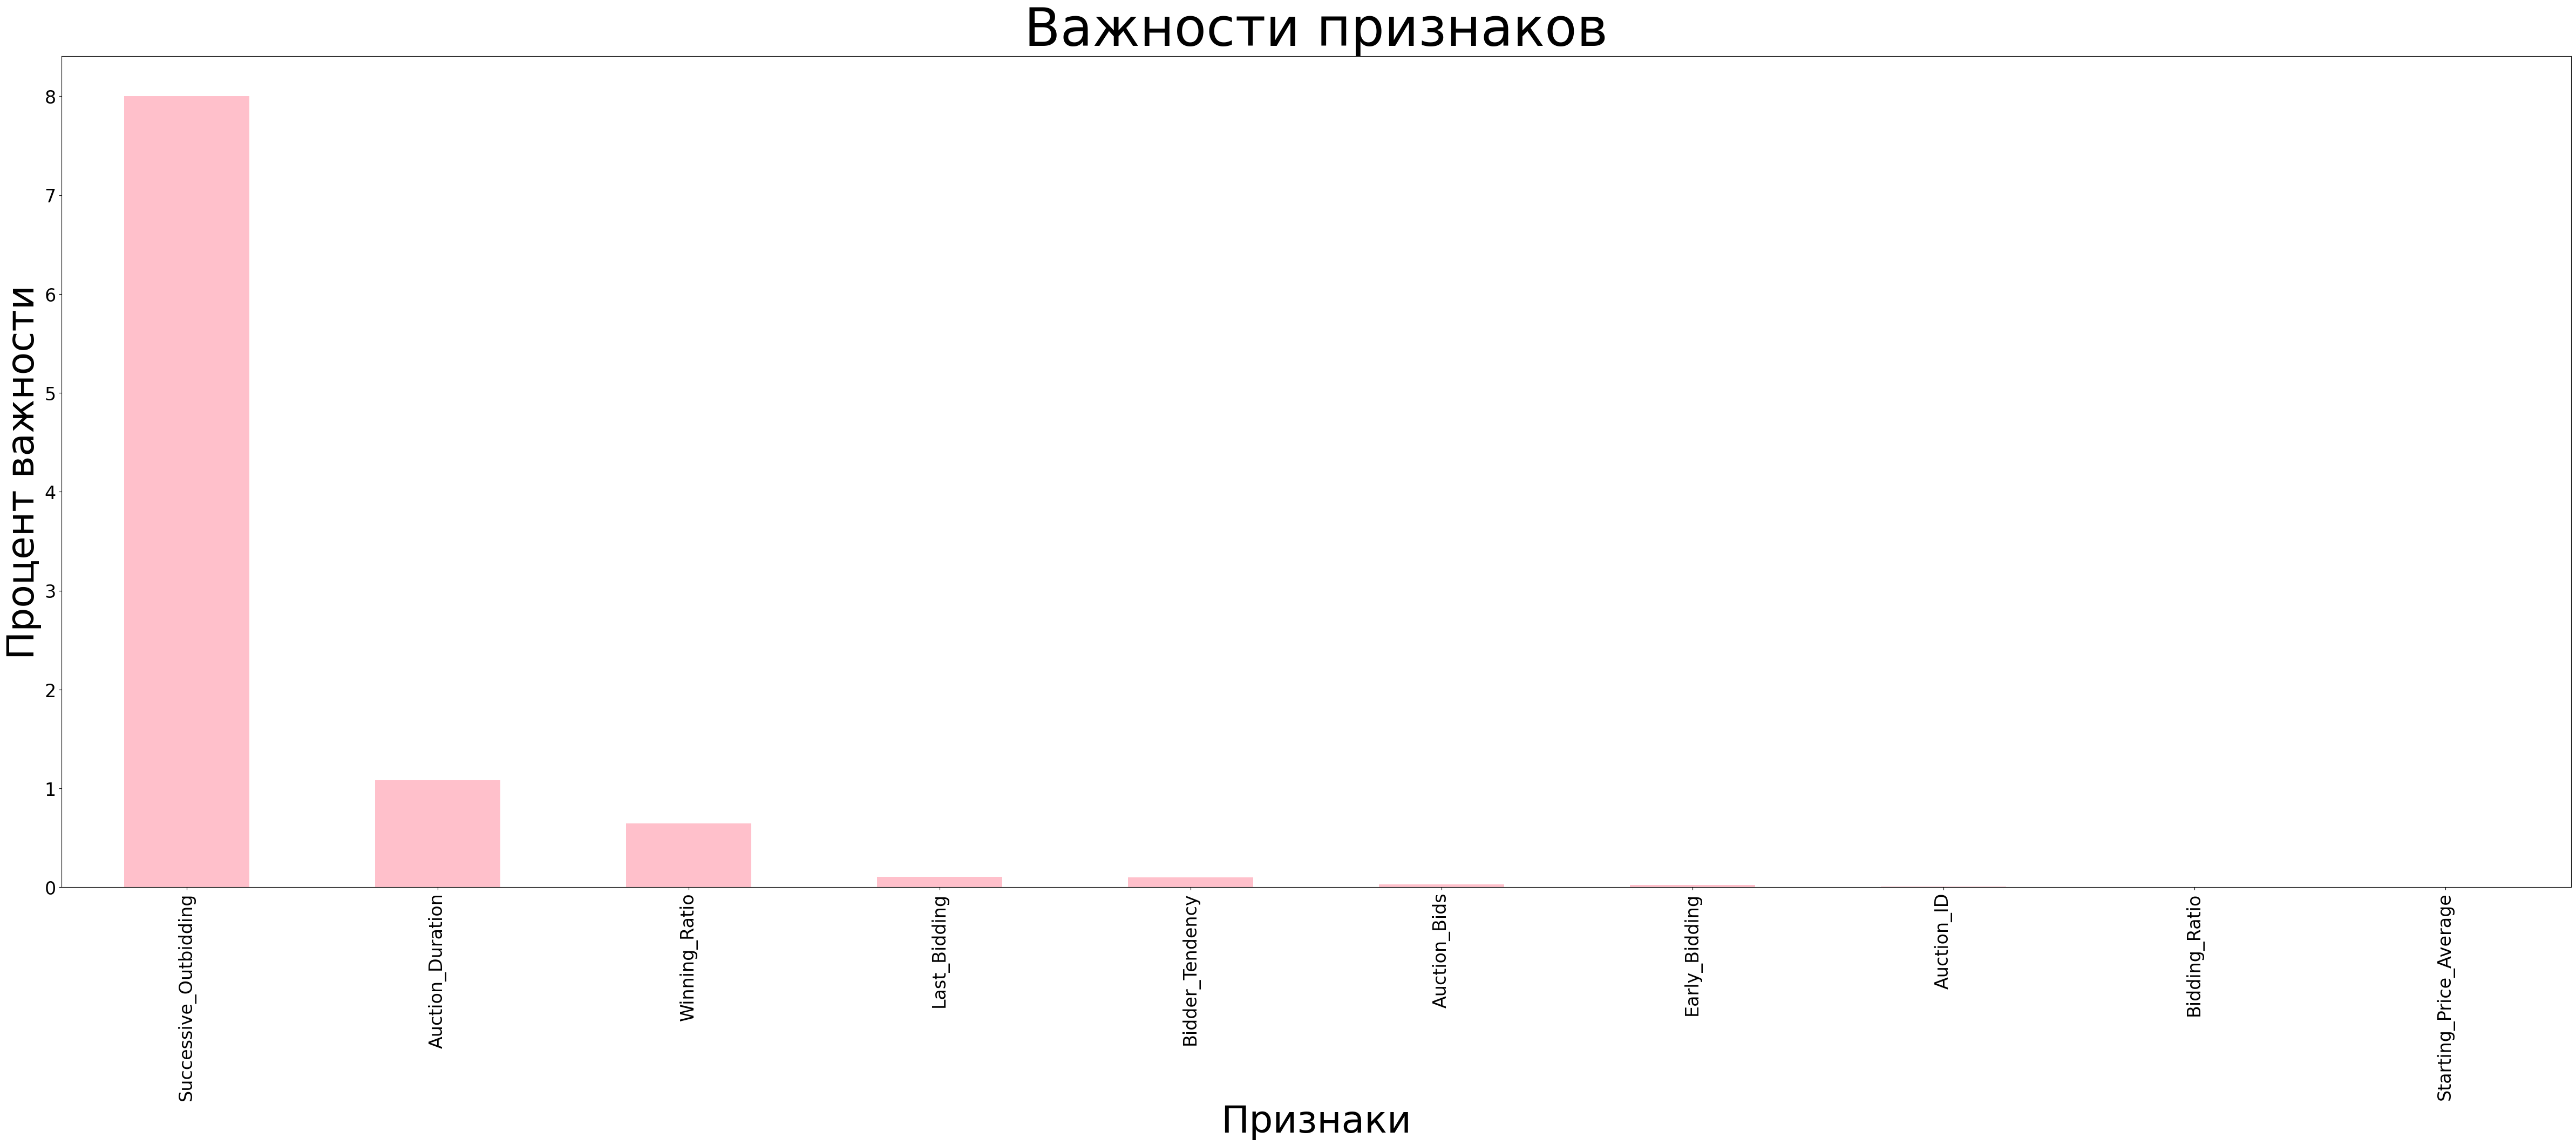

In [16]:
df_import = pd.DataFrame(importances, columns = ['Feature importances'], index=columns)
df_import['Percentage'] = pd.DataFrame((df_import.sort_values(by= ['Feature importances'], ascending=False)/df_import.shape[0])*100)
pd.options.display.float_format = "{:.2f}".format 
df_import=df_import.sort_values(by= ['Percentage'], ascending=False)

# plotting features importances
g = df_import['Percentage'].plot(kind = 'bar', figsize=(60,20), fontsize=24, color = 'pink')
g.set_title('Важности признаков', fontsize=70)
g.set_xlabel('Признаки', fontsize=50)
g.set_ylabel('Процент важности', fontsize=50)

Мы видим, что  наиболее важными функциями для прогнозирования целевой переменной являются:
- Successive_Outbidding
- Auction_Duration
- Winning_Ratio

**Для уменьшения размерности данных и исключения малозначащих признаков существуют различные методы:**

- Главные компоненты (Principal Component Analysis, PCA): PCA находит новые некоррелированные переменные, называемые главными компонентами, которые объясняют наибольшую долю дисперсии в исходных данных. Путем выбора определенного числа главных компонент можно уменьшить размерность данных.
- Линейный дискриминантный анализ (Linear Discriminant Analysis, LDA): LDA используется для проекции данных на пространство меньшей размерности, при этом максимизируется разделимость классов. Это особенно полезно для задач классификации.
- t-Снижение размерности (t-Distributed Stochastic Neighbor Embedding, t-SNE): t-SNE позволяет визуализировать данные высокой размерности в двух или трех измерениях, сохраняя при этом относительные расстояния между точками. Он может быть полезен для визуализации данных или обнаружения паттернов.
- Метод случайных проекций (Random Projection): Этот метод случайным образом проецирует исходные данные на подпространство меньшей размерности. Он основывается на идее, что случайные проекции сохраняют некоторые структуры данных.
- Выборка признаков на основе важности (Feature Selection based on Importance): Используется алгоритмы машинного обучения для оценки важности каждого признака в задаче классификации или регрессии. Затем можно выбрать наиболее важные признаки и исключить малозначащие.
- Рекурсивное устранение признаков (Recursive Feature Elimination, RFE): RFE последовательно удаляет наименее важные признаки на основе модели машинного обучения и переобучается на оставшихся признаках. Этот процесс продолжается до достижения определенного количества признаков.
- Метод главных осей (Factor Analysis of Mixed Data, FAMD): FAMD используется для уменьшения размерности смешанных (категориальных и числовых) данных. Он выполняет факторный анализ для определения латентных факторов, которые лучше объясняют вариацию в данных.

Text(0, 0.5, 'Совокупная  дисперсия')

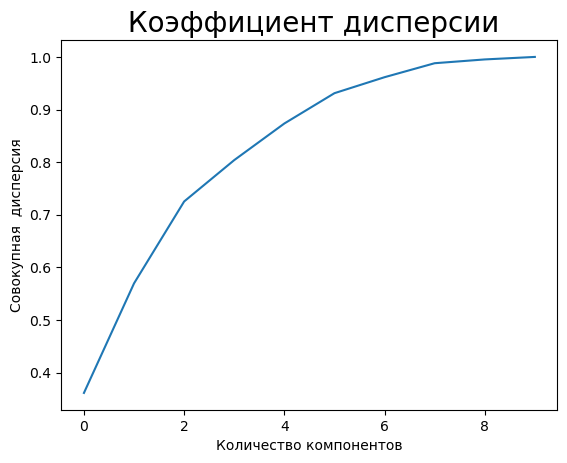

In [17]:
# Использую наиболее знакомый метод (Principal Component Analysis, PCA)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title(' Коэффициент дисперсии', fontsize = 20)
plt.xlabel('Количество компонентов')
plt.ylabel('Совокупная  дисперсия')

**Из графика видно, что для сохранения 90% исходных данных нам нужно использовать 6 компонентов.**

In [18]:
pca = PCA(n_components=6)
projected = pca.fit_transform(X)

In [19]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.36141299, 0.20827264, 0.15559512, 0.07863725, 0.06955875,
       0.05760696])

**Первые 3 компонента содержат наибольшее количество данных, последние три содержат менее 20%.\
На осеновании анализа возможно создать DataFrame с 6 компонентами и целевой переменной.**

In [20]:
principal_df = pd.DataFrame(data = projected, columns = ['PC 1','PC 2','PC 3','PC 4','PC 5','PC 6'])
df_pca = principal_df.join(y, how='outer')
df_pca.head(5)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,Class
0,-0.28,-0.28,0.74,-0.19,0.02,-0.28,0
1,-0.34,-0.13,0.82,-0.20,-0.00,-0.47,0
2,-0.37,-0.09,0.87,-0.20,-0.00,-0.46,0
3,-0.28,-0.01,0.80,-0.21,-0.00,-0.48,0
4,-0.82,-0.21,-0.04,-0.04,0.28,-0.09,0


Также для более чёткого разделения между классами можно использовать (Linear Discriminant Analysis, LDA)

**Линейный дискриминантный анализ, или LDA, использует информацию из обоих признаков для создания новой оси и проецирует данные на новую ось таким образом, чтобы минимизировать дисперсию и максимизировать расстояние между средними значениями двух классов.**

In [21]:
lda = LinearDiscriminantAnalysis()
x_lda = lda.fit_transform(X,y)

In [22]:
lda.explained_variance_ratio_

array([1.])

создадим DataFrame и записать туда LDA 1, который мы получили, а также целевую переменную.

In [23]:
linear_df = pd.DataFrame(data = x_lda, columns = ['LDA 1'])
df_lda = linear_df.join(y, how='outer')
df_lda.head(11)

,LDA 1,Class
0,-0.71,0
1,-0.64,0
2,-0.61,0
3,-0.61,0
4,-0.82,0
5,-0.72,0
6,-0.70,0
7,7.61,1
8,7.40,1
9,3.38,1


отрицательные числа в LDA 1 относятся к «0 классу», а положительные числа относятся к «1 классу».

Первый алгоритм, с которым я буду работать, — это логистическая регрессия. Логистическая регрессия — это алгоритм классификации контролируемого машинного обучения, который используется для прогнозирования вероятности категориальной зависимой переменной. (Ли, 2017). Причина, по которой я буду использовать алгоритм логистической регрессии, заключается в том, что он предназначен для двухклассовых (бинарных) задач, моделируя цель с использованием биномиальной функции распределения вероятностей.

In [24]:
X = df_lda.drop(columns='Class')
y = df_lda['Class']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4424, 1), (1897, 1), (4424,), (1897,))

Logistic Regression

In [26]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [27]:
# Необходимо определить наилучшие параметры модели, чтобы получить максимально возможную точность.
# Я буду работать со следующими параметрами LogisticRegression:

#Solver - Алгоритм для использования в задаче оптимизации:

#Для небольших наборов данных хорошим выбором является «liblinear», тогда как «sag» и «saga» работают быстрее для больших;
#Для многоклассовых задач только «newton-cg», «sag», «saga» и «lbfgs» обрабатывают полиномиальные потери;
#«liblinear» ограничен схемами «один против остальных».

#Penalty - Укажите норму штрафа:

#'none': штраф не добавляется;
#'l2': добавьте штрафной срок L2, и это выбор по умолчанию;
#'l1': добавить штрафной срок L1;

#C_values - Обратная сила регуляризации; должен быть положительным числом с плавающей запятой.
#Как и в машинах опорных векторов, меньшие значения определяют более сильную регуляризацию.

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none','l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [28]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.979908 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Мы определили, что наилучшая точность будет достигнута при использовании C=0,1, штрафа = 'l2' и решателя = 'liblinear'. Теперь давайте обучим модель с этими параметрами:

In [30]:
logreg = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [31]:
print('Training score: {:.3f}'.format(logreg.score(X_train,y_train)))
print('Testing score: {:.3f}'.format(logreg.score(X_test,y_test)))

Training score: 0.981
Testing score: 0.978


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1690
           1       0.85      0.98      0.91       207

    accuracy                           0.98      1897
   macro avg       0.92      0.98      0.95      1897
weighted avg       0.98      0.98      0.98      1897

AxesSubplot(0.125,0.11;0.775x0.77)


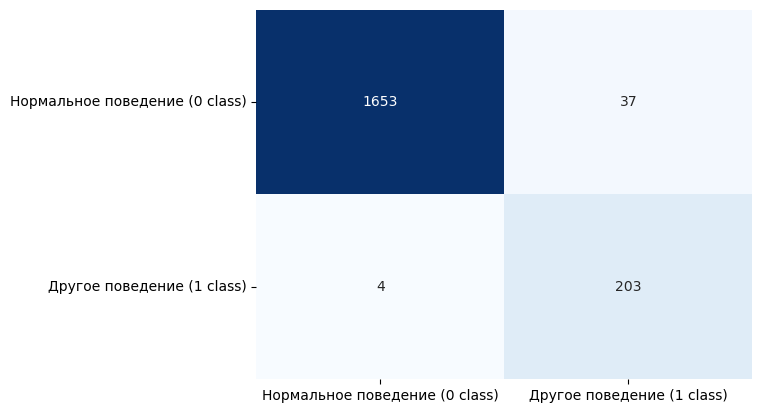

In [32]:
print(classification_report(y_test, y_pred))
print(sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.4g',                 
                 xticklabels=['Нормальное поведение (0 class)','Другое поведение (1 class)'],                
                 yticklabels=['Нормальное поведение (0 class)','Другое поведение (1 class)'],                  
                 cbar=False, cmap='Blues'))

модель показывает себя  хорошо  
- из 1984  (0 класса) только 55 были предсказаны как ложноположительные,
- из более 224 значений (1 класса) только 1 было предсказано как ложноотрицательные.

### 6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

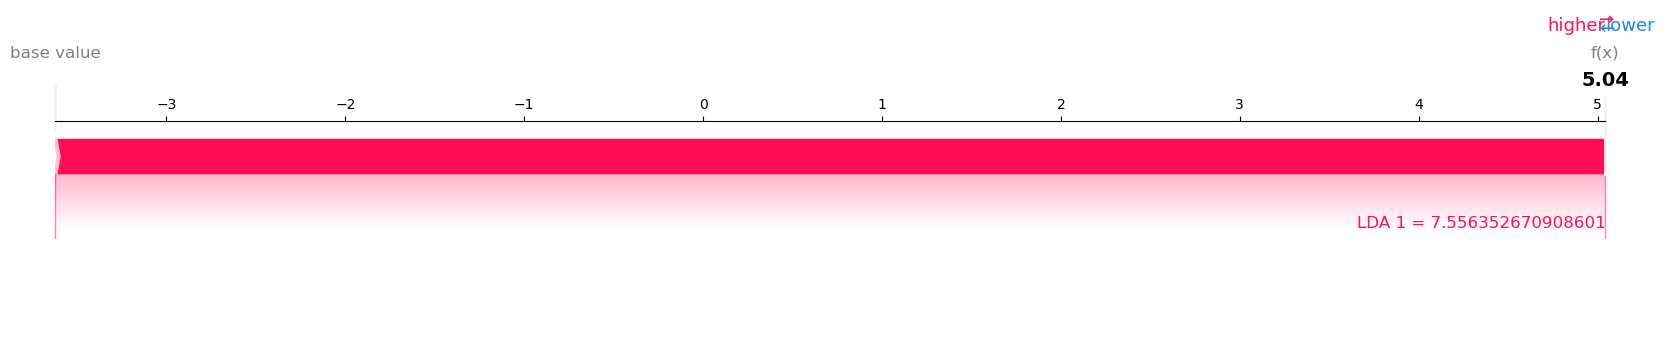

In [33]:
import shap

# Инициализация Explainer с моделью и обучающими данными
explainer = shap.Explainer(logreg, X_train)

# Получение SHAP значений для наблюдения
shap_values = explainer.shap_values(X_test)

# Вывод force plot
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)

# Интерпретация результатов
# Результаты force plot позволяют понять, какие признаки вносят наибольший вклад в предсказание для данного наблюдения.
# Синие признаки с положительным вкладом увеличивают предсказание, красные признаки с отрицательным вкладом уменьшают предсказание.
# Более яркие цвета указывают на более сильный вклад признака.
# Вы можете проанализировать force plot, чтобы понять, какие признаки влияют на предсказание и в каком направлении.


Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value